### Run through MRI scans using lymph node annotations and save as 2D and 3D patches, with and without augmentation

In [2]:
first_time = True
crop_2D = True
crop_3D = False
save_augmented_data = True

In [3]:
# Torchio
import torchio as tio
# from tqdm.auto import tqdm
from torchio.transforms import HistogramStandardization

# from scipy import stats
# import multiprocessing
# import pickle

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# import torchvision
# import torch.nn as nn
# import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import pytorch_msssim


# MRI scan and mask data loading and pre-processing
import pydicom
import nibabel as nib

# Maths / plotting / utilities
import numpy as np
import os
import sys
from time import perf_counter
import matplotlib.pyplot as plt
import random
import copy

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from VAE.utils.utility_code import find_centers_and_bounding_boxes, find_centers_and_bounding_boxes_32, find_bounding_cubes

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


torch.cuda.empty_cache()

data_directory = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1"
mask_directory = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_segmentations"
save_file_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data"


if not first_time:
    # get file names for mri and mask files
    dir = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_preprocessed"
    mri_nii_paths, mask_nii_paths = [], []
    for root, _, files in os.walk(dir):
        for file in files:
            if file.endswith('.nii') and 'mri' in file:
                mri_nii_paths.append(os.path.join(root, file))
            if file.endswith('.nii') and 'mask' in file:
                mask_nii_paths.append(os.path.join(root, file))
    
    # check that the mri and mask files are correctly matched
    for i in range(len(mri_nii_paths)):
        #print(mri_nii_paths[i][63:72], mask_nii_paths[i][63:72])
        assert mri_nii_paths[i][63:72] == mask_nii_paths[i][63:72]      # pat_id == pat_id 
    
    bounding_boxes_dict = np.load(os.path.join(save_file_path, 'bounding_boxes.npy'), allow_pickle=True).item()


Using device: cuda


In [ ]:
mask_file_paths = []
multiple_masks = {}
patient_ids = []

# root_files_list = []
# for root, _, files in os.walk(mask_directory):
#     root_files_list.append([root, files])
# root_files_list = sorted(root_files_list, key=lambda x: x[0])

for root, _, files in os.walk(mask_directory):
    patient_scans = []
    for file in files:
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            if file[:3] == 'tra' and 'sfov' in file and 'LNs' in file:
                if 'maybe' not in file:
                    mask_file_paths.append(os.path.join(root, file))
                    patient_scans.append(os.path.join(root, file))
                    patient_ids.append(file[-25:-4])
            # else:
            #     print(file)

    if len(patient_scans) > 1:
        multiple_masks[patient_scans[0][64:85]] = [patient_scans[i][-35:-30] for i in range(len(patient_scans))]
        #print(len(patient_scans))
        
        
print('Number of available masks:', len(mask_file_paths))
print('Multiple masks:', multiple_masks)
print("total patients with multiple scans with LNs:", len(multiple_masks))
patient_ids = list(set(patient_ids))
print("total patients with scans containing LNs:", len(patient_ids))

mri_file_paths = []
mask_data_dict = {}
root_files_list = []

for root, _, files in os.walk(data_directory):
    pat_id = root[50:71]
    # check its a patient with a mask
    if pat_id in patient_ids:
        pat_scan_names = []
        pat_masks = []
        for mask in mask_file_paths:
            if pat_id in mask:
                pat_scan_names.append(mask[-35:-30]) # get scan name t2_tse_tra / tra_sfov / sfov1 / sfov2 etc
                pat_masks.append(mask)

                
        if 'reformatted' in root and 'tra_sfov' in root and 'maybe' not in root:
            # add the scans in order of the mask names
            for i, scan in enumerate(pat_scan_names):
                if scan in root:
                    mri_file_paths.append(root) 
                    mask_data_dict[root] = pat_masks[i]


        if 't2_tse_tra' in root:
            mri_file_paths.append(root)
            mask_data_dict[root] = pat_masks[0]


assert len(mri_file_paths) == len(mask_data_dict)

# check that keys and values are correctly matched
i = 0
for k, v in mask_data_dict.items():
    assert k == mri_file_paths[i]
    assert v == mask_file_paths[i]
    i+=1

# for i, path in enumerate(mri_file_paths):
#     if path[-9:] not in mask_file_paths[i]:
#         print(path[-10:], mask_file_paths[i], i)

mask_file_names = []
for mask_path in mask_file_paths:
    name = mask_path[86:95]
    if name[-1] == '_':
        name = name[:-1]
    mask_file_names.append(name)

# Number of available masks: 190
# total patients with multiple scans with LNs: 21
# total patients with scans containing LNs: 168

In [6]:
def pre_process_and_save_data(mri_file_paths, mask_data_dict, get_mri_landmarks=False):
    time_start = perf_counter()
    subjects = []
    origins_before, spacing_before, shapes_before = [], [], []
    origins_after, spacing_after, shapes_after = [], [], []
    for i, mri_path in enumerate(mri_file_paths):
        mask_path = mask_data_dict[mri_path]
        
        subject = tio.Subject(
            mri=tio.ScalarImage(mri_path),
            mask=tio.LabelMap(mask_path),
        )

        #if i < 5:
         #   print('before', i, subject['mri'].shape, subject['mri'].origin, subject['mri'].spacing, 'mask', subject['mask'].shape, subject['mask'].origin, subject['mask'].spacing)

        # first time save raw data to calculate mri landmarks
        if get_mri_landmarks:
            pass
        else:
            origins_before.append(subject['mri'].origin)
            spacing_before.append(subject['mri'].spacing)
            shapes_before.append(subject['mri'].shape)
            histogram_landmarks = np.load(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\mri_landmarks.npy")
            histogram_landmarks = {'mri': histogram_landmarks}
            # run base transform to make 1mm voxel size and standard image shape
            transform1 = tio.Compose([
                tio.ToCanonical(), # constant orientation
                #tio.BiasField(p=0.3),  # Bias field correction try turning on see if it makes VAE better
                tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensity values to the range [0, 1]
                tio.ZNormalization(),  # Zero-mean, unit-variance normalization
                tio.HistogramStandardization(landmarks=histogram_landmarks),  # Histogram standardization
                tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensity values to the range [0, 1]
            ])
                
            transform2 = tio.Compose([
                tio.ToCanonical(), # constant orientation 
                #tio.BiasField(p=0.3),  # Bias field correction
                tio.Resample((0.573, 0.573, 3.3)), # Resample to a standard voxel size for those more than 5% away from these values
                tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensity values to the range [0, 1]
                tio.ZNormalization(),  # Zero-mean, unit-variance normalization
                tio.HistogramStandardization(landmarks=histogram_landmarks),  # Histogram standardization
                tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensity values to the range [0, 1]
            ])
    
            # if within 5% of 0.573mm isotropic voxel size and 3.3mm slice thickness use transform1 else use transform2
            if (0.573 - 0.573*0.05 <= subject['mri'].spacing[0] <= 0.573 + 0.573*0.05) and (0.573 - 0.573*0.05 <= subject['mri'].spacing[1] <= 0.573 + 0.573*0.05) and (3.3 - 3.3*0.05 <= subject['mri'].spacing[2] <= 3.3 + 3.3*0.05):
                transform = transform1
            else:
                #print('Resample', subject['mri'].spacing)
                transform = transform2
            
            subject = transform(subject)
            

            for key, img in subject.items():
                data = img.data
                # if key == 'mri':
                #     print(data)
                if (('925F0133B8_62823a01e6' in mri_path) or ('E17A12A951_b8c6ca7250' in mri_path) or ('D755F9DCC5_6398522178' in mri_path)) and (key == 'mri') and (get_mri_landmarks==False):
                    # crop last slice of this mri which has an extra blank slice 
                    print(i, subject['mri'].shape, subject['mask'].shape)
                    print('sum on last slice', data[:,:,:,-1].sum())
                    if data[:,:,:,-1].sum() == 0:
                        data = data[:,:,:,:-1]
                        subject[key].set_data(data)
                        print(i, 'cut last slice as it is empty', subject['mri'].shape, subject['mask'].shape)
    
                    
                if data.shape[-1] > data.shape[-2]:
                    #print('before', subject['mri'].shape, subject['mask'].shape)
                    data = data.permute(0, 1, 3, 2)  # Swap the last two dimensions
                    subject[key].set_data(data)
                    #print('after', subject['mri'].shape, subject['mask'].shape)
                    
            #if i < 5:        # if i < 5:
            #     print('after', i, subject['mri'].shape, subject['mri'].origin, subject['mri'].spacing, 'mask', subject['mask'].shape, subject['mask'].origin, subject['mask'].spacing)
    
            origins_after.append(subject['mri'].origin)
            spacing_after.append(subject['mri'].spacing)
            shapes_after.append(subject['mri'].shape)
            assert subject['mri'].shape == subject['mask'].shape
        
        for image_name, image in subject.items():
            image.save(r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_preprocessed\{}_{}_{}.nii".format(
                mri_file_paths[i][50:71], mask_file_names[i], image_name))

        subjects.append(subject)

            
        # Save the dataset as a pickle file    
        # with open("subjects_dataset.pickle", "wb") as f:
        #     pickle.dump(dataset, f) # this loads all in one go - use different storage - save as numpy arrays instead? - one file per image/mask

        
        # if subject['mri'].shape != subject['mask'].shape:
        #     print(i, subject['mri'].shape, subject['mask'].shape)
        #     print(mri_file_paths[i][50:71], mask_file_names[i])
        
        
    dataset = tio.SubjectsDataset(subjects)
    print("Time to create dataset:", perf_counter() - time_start) # 902 seconds 
    print('number of scans with LNs visable:', len(dataset))
    
    return dataset, origins_before, spacing_before, shapes_before, origins_after, spacing_after, shapes_after



In [ ]:
if first_time:
    # save raw data to calculate mri landmarks in torchio
    dataset, origins_before, spacing_before, shapes_before, origins_after, spacing_after, shapes_after = pre_process_and_save_data(mri_file_paths, mask_data_dict, get_mri_landmarks=True)
    mri_landmarks_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\mri_landmarks.npy"
    
    # get file names for mri and mask files
    dir = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_preprocessed"
    mri_nii_paths, mask_nii_paths = [], []
    for root, _, files in os.walk(dir):
        for file in files:
            if file.endswith('.nii') and 'mri' in file:
                mri_nii_paths.append(os.path.join(root, file))
            if file.endswith('.nii') and 'mask' in file:
                mask_nii_paths.append(os.path.join(root, file))
    # check that the mri and mask files are correctly matched
    for i in range(len(mri_nii_paths)):
        assert mri_nii_paths[i][63:72] == mask_nii_paths[i][63:72]      # pat_id == pat_id
    
    mri_landmarks = HistogramStandardization.train(mri_nii_paths)
    np.save(mri_landmarks_path, mri_landmarks)
    #[5.551115123125783e-17, 4.94843191080177, 10.453543757247637, 13.50913314139026, 17.007953129642505, 25.970004566325088, 36.96525089766525, 48.222000263150626, 58.141716351551956, 62.60895835613496, 66.90955976069398, 76.40963532981661, 100.00000000000001]
    
    # save data with preprocessing transforms applied
    dataset, origins_before, spacing_before, shapes_before, origins_after, spacing_after, shapes_after = pre_process_and_save_data(mri_file_paths, mask_data_dict, get_mri_landmarks=False)
    
    random_idx = list(set(np.random.randint(0, len(dataset), 20)))[:3]
    for idx in random_idx:
        dataset[idx].plot()

#Time to create dataset: 42.28109150007367
# number of scans with LNs visable: 190

In [8]:
# get file names for mri and mask files
dir = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_preprocessed"
mri_nii_paths, mask_nii_paths = [], []
for root, _, files in os.walk(dir):
    for file in files:
        if file.endswith('.nii') and 'mri' in file:
            mri_nii_paths.append(os.path.join(root, file))
        if file.endswith('.nii') and 'mask' in file:
            mask_nii_paths.append(os.path.join(root, file))

# check that the mri and mask files are correctly matched
for i in range(len(mri_nii_paths)):
    #print(mri_nii_paths[i][63:72], mask_nii_paths[i][63:72])
    assert mri_nii_paths[i][63:72] == mask_nii_paths[i][63:72]      # pat_id == pat_id 


In [ ]:
if first_time:
    save_file_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data"
    bounding_boxes_dict = {}
    bounding_boxes_dict2 = {}
    bounding_cubes_dict = {}
    for mask_path in mask_nii_paths:
        mask = nib.load(mask_path)
        mask_np = mask.get_fdata()
        mask_np = np.transpose(mask_np, (2, 0, 1))
        bounding_boxes = find_centers_and_bounding_boxes_32(mask_np)
        bounding_boxes2 = find_centers_and_bounding_boxes(mask_np)
        bounding_cubes = find_bounding_cubes(mask_np)
        bounding_boxes_dict[mask_path] = bounding_boxes
        bounding_boxes_dict2[mask_path] = bounding_boxes2
        bounding_cubes_dict[mask_path] = bounding_cubes
    
    # save the bounding boxes and centres
    np.save(os.path.join(save_file_path, 'bounding_boxes.npy'), bounding_boxes_dict)
    np.save(os.path.join(save_file_path, 'bounding_boxes2.npy'), bounding_boxes_dict2)
    np.save(os.path.join(save_file_path, 'bounding_cubes.npy'), bounding_cubes_dict)
    
    
    # bounding_boxes = np.load(os.path.join(save_file_path, 'bounding_boxes.npy'), allow_pickle=True).item()
    # bounding_boxes2 = np.load(os.path.join(save_file_path, 'bounding_boxes2.npy'), allow_pickle=True).item()
    
    x, y, z = [], [], []
    for k, v in bounding_boxes_dict2.items():
        for k1, v1 in v.items():
            x.append(v1['size'][0])
            y.append(v1['size'][1])
            z.append(v1['size'][2])
            if v1['size'][1] > 32 or v1['size'][2] > 32:
                print(v1['size'], k1, k)
            #if v1['size'][0] > 1:
            #   print(v1['size'], k1, k)
    
    print("min x:", min(x), "min y:", min(y), "min z:", min(z))
    print("max x:", max(x), "max y:", max(y), "max z:", max(z))
    
    # count number of lymph nodes
    num_lymph_nodes = 0
    for k, v in bounding_boxes_dict2.items():
        num_lymph_nodes += len(v)
    print("total number of lymph nodes:", num_lymph_nodes)


# min x: 1 min y: 2 min z: 2
# max x: 4 max y: 21 max z: 22
# total number of lymph nodes: 1115

In [ ]:
if crop_2D:
    # for 2d cropping and saving 
    time_start = perf_counter()
    samples = 0
    for i, mri_path in enumerate(mri_nii_paths):
        mask_path = mask_nii_paths[i]
        assert mri_nii_paths[i][63:72] == mask_nii_paths[i][63:72] # check same patient id
    
        subject = tio.Subject(
            mri=tio.ScalarImage(mri_path),
            mask=tio.LabelMap(mask_path),
        )
        #print(i, subject['mri'].shape, subject['mask'].shape)
    
        bboxes_dict = bounding_boxes_dict[mask_path]
    
    
        for bbox_key, bbox_info in bboxes_dict.items():
            bbox = bbox_info['bounding_box']
    
            # Get bounding box coordinates (in format (x_min, y_min, z_min), (x_max, y_max, z_max))
            z_min, x_min, y_min = bbox[0]
            z_max, x_max, y_max = bbox[1]
    
    
            for key, img in subject.items():
                data = img.data   # Convert to a PyTorch tensor
                #print(key, data.shape)
                cropped_data = data[:, x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
                assert cropped_data.shape ==  (1, 32, 32, 1)
                cropped_image = tio.ScalarImage(tensor=cropped_data, affine=img.affine)
    
    
                # Save the cropped image as a NIfTI file
                if key == 'mri':
                    save_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices\mri\{}_{}_{}_{}.nii".format(
                        mri_path[63:-4], i, int(bbox_key[0]), int(bbox_key[1]))  # (patient number, patient LN number, slice_idx)
                if key == 'mask':
                    save_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices\mask\{}_{}_{}_{}.nii".format(
                        mask_path[63:-4], i, int(bbox_key[0]), int(bbox_key[1]))
    
                cropped_image.save(save_path)
                samples += 1
    
    
    print('Number of lymph node slices in dataset:', samples/2)
    print("Time to create dataset:", perf_counter() - time_start) #  seconds

# Number of lymph node slices in dataset: 1569.0

In [12]:
if crop_3D:
    # for 3d cropping and saving
    time_start = perf_counter()
    samples = 0
    for i, mri_path in enumerate(mri_nii_paths):
        mask_path = mask_nii_paths[i]
        assert mri_nii_paths[i][63:72] == mask_nii_paths[i][63:72] # check same patient id
    
        subject = tio.Subject(
            mri=tio.ScalarImage(mri_path),
            mask=tio.LabelMap(mask_path),
        )
        #print(i, subject['mri'].shape, subject['mask'].shape)
    
        bboxes_dict = bounding_cubes_dict[mask_path]
    
    
        for bbox_key, bbox_info in bboxes_dict.items():
            bbox = bbox_info['bounding_cube']
    
            # Get bounding box coordinates (in format (x_min, y_min, z_min), (x_max, y_max, z_max))
            z_min, x_min, y_min = bbox[0]
            z_max, x_max, y_max = bbox[1]
    
    
            for key, img in subject.items():
                data = img.data   # Convert to a PyTorch tensor
                #print(key, data.shape)
                cropped_data = data[:, x_min:x_max, y_min:y_max, z_min:z_max]
                assert cropped_data.shape ==  (1, 48, 48, 4)
                cropped_image = tio.ScalarImage(tensor=cropped_data, affine=img.affine)
    
    
                # Save the cropped image as a NIfTI file
                if key == 'mri':
                    save_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_3D_nodes\mri\{}_{}_{}.nii".format(
                        mri_path[63:-4], i, int(bbox_key))  # (patient number, patient LN number, slice_idx)
                if key == 'mask':
                    save_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_3D_nodes\mask\{}_{}_{}.nii".format(
                        mask_path[63:-4], i, int(bbox_key))
    
                cropped_image.save(save_path)
                samples += 1
    
    
    print('Number of lymph nodes in dataset:', samples/2)
    print("Time to create dataset:", perf_counter() - time_start) #  seconds

### Save 25 augmented 2D patches for each sample
#### Augmentation includes:
#### Flipping in x and y axes 50% of the time
#### Moving centre of patch by +/- 8 pixels in x and y
#### Applying Gaussian noise / blurring / gamma adjustment / bias field correction


In [14]:
example_noise = [int(np.random.normal(0, 6)) for _ in range(50)]
print('Example noise', example_noise)

def add_noise_to_bbox(bounding_boxes, mri_shape):
    new_bboxes = copy.deepcopy(bounding_boxes)

    for key, bbox in bounding_boxes.items():
        x_change = int(np.random.normal(0, 6))
        y_change = int(np.random.normal(0, 6))

        # set max noise to be +/- 8
        if x_change > 8:
            x_change = 8
        if x_change < -8:
            x_change = -8
        if y_change > 8:
            y_change = 8
        if y_change < -8:
            y_change = -8

        center = bbox['center']

        #print('Original', bbox['bounding_box'])
        new_x_min = bbox['bounding_box'][0][1] + x_change
        new_x_max = bbox['bounding_box'][1][1] + x_change
        new_y_min = bbox['bounding_box'][0][2] + y_change
        new_y_max = bbox['bounding_box'][1][2] + y_change

        # check new bounding box is within image
        assert new_x_min >= 0 and new_x_max < max(mri_shape) and new_y_min >= 0 and new_y_max < max(mri_shape)
        # check centre is still within bounding box
        assert new_x_min < center[1] < new_x_max and new_y_min < center[2] < new_y_max

        new_bbox = ((bbox['bounding_box'][0][0], new_x_min, new_y_min), (bbox['bounding_box'][1][0], new_x_max, new_y_max))
        new_bboxes[key]['bounding_box'] = new_bbox
        #print('New bbox', new_bbox)
    return new_bboxes



def crop_and_plot(subject, idx, bboxes_dict):
    bbox_key, bbox_info = list(bboxes_dict.items())[idx]
    bbox = bbox_info['bounding_box']

    # Get bounding box coordinates (in format (x_min, y_min, z_min), (x_max, y_max, z_max))
    z_min, x_min, y_min = bbox[0]
    z_max, x_max, y_max = bbox[1]

    for key, img in subject.items():
        data = img.data   # Convert to a PyTorch tensor
        cropped_data = data[:, x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

        assert cropped_data.shape == (1, 32, 32, 1)
        if key == 'mri':
            mri = tio.ScalarImage(tensor=cropped_data, affine=img.affine)
        if key == 'mask':
            mask = tio.LabelMap(tensor=cropped_data, affine=img.affine)

    cropped_subject = tio.Subject(mri=mri, mask=mask)
    cropped_subject.plot()
    return cropped_subject

img = nib.load(mask_nii_paths[0])
# Get the image data
img_data = img.get_fdata()
# get shape 
mri_shape = img_data.shape
add_noise_to_bbox(bounding_boxes_dict[mask_nii_paths[0]], mri_shape)

Example noise [-5, -3, 0, -3, 3, 2, 3, 8, 1, 2, 1, -1, 8, -1, -7, -5, 7, -6, 7, -2, 6, 7, -3, 8, -1, -7, 0, 5, 0, -1, 2, 7, -8, -7, -3, 5, 1, 4, -5, -2, 2, 14, 2, -2, 3, 1, -1, 3, 3, -5]


{(1.0, 9): {'center': (9, 168, 137),
  'bounding_box': ((9, 153, 122), (9, 184, 153))},
 (2.0, 12): {'center': (12, 167, 121),
  'bounding_box': ((12, 143, 110), (12, 174, 141))},
 (3.0, 15): {'center': (15, 166, 130),
  'bounding_box': ((15, 152, 106), (15, 183, 137))},
 (4.0, 16): {'center': (16, 148, 133),
  'bounding_box': ((16, 130, 115), (16, 161, 146))},
 (5.0, 18): {'center': (18, 161, 92),
  'bounding_box': ((18, 150, 77), (18, 181, 108))},
 (6.0, 21): {'center': (21, 148, 161),
  'bounding_box': ((21, 126, 143), (21, 157, 174))}}

Full scan SSIM: tensor(0.6365)
Original


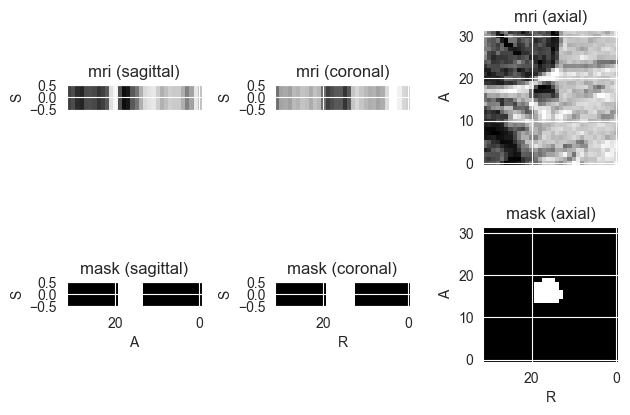

Augmented


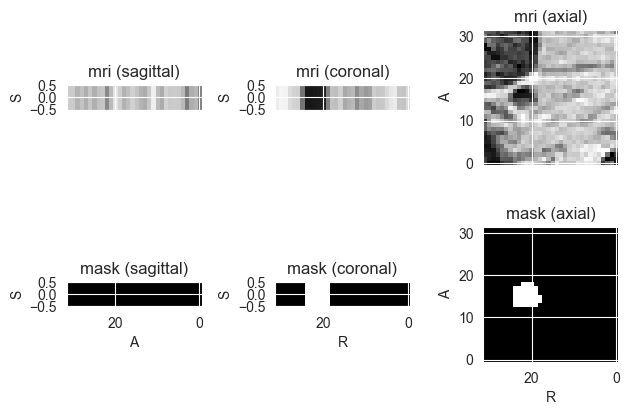

Original vs Augmented SSIM: tensor(0.2456)
Full scan SSIM: tensor(0.0973)
Original


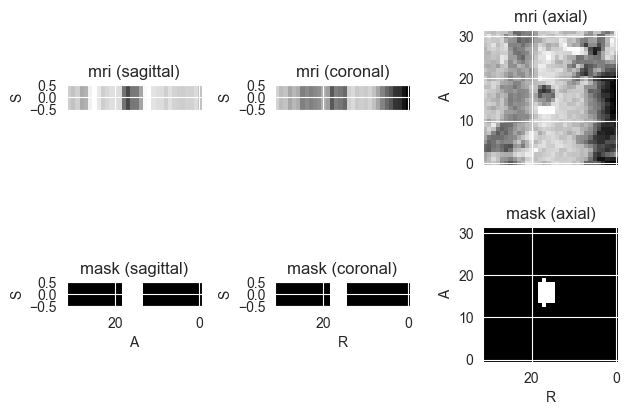

Augmented


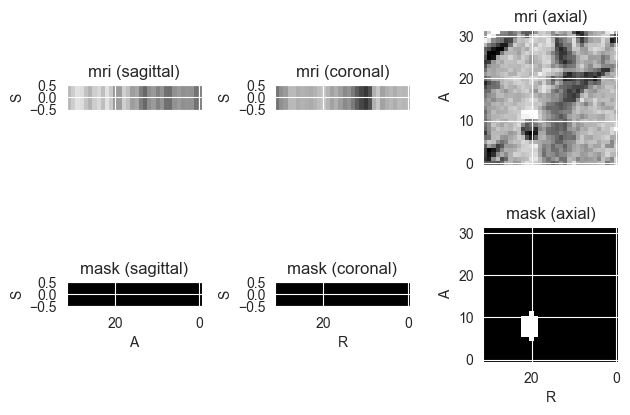

Original vs Augmented SSIM: tensor(0.1438)
Full scan SSIM: tensor(0.9039)
Original


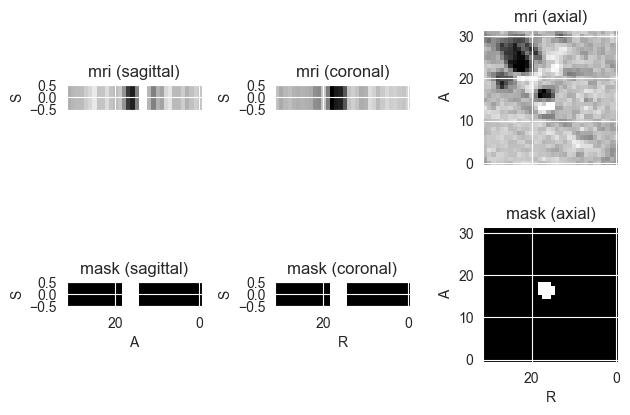

Augmented


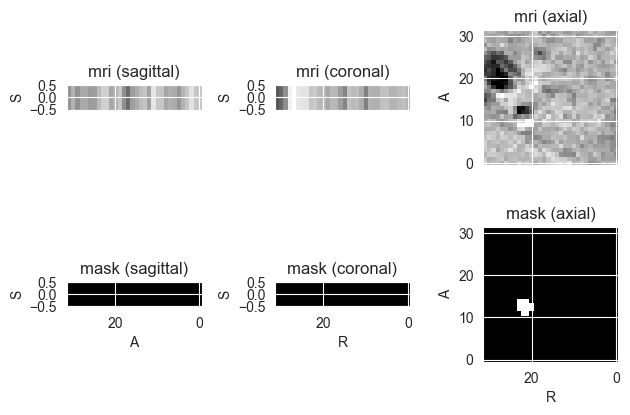

Original vs Augmented SSIM: tensor(0.2680)
Full scan SSIM: tensor(0.7337)
Original


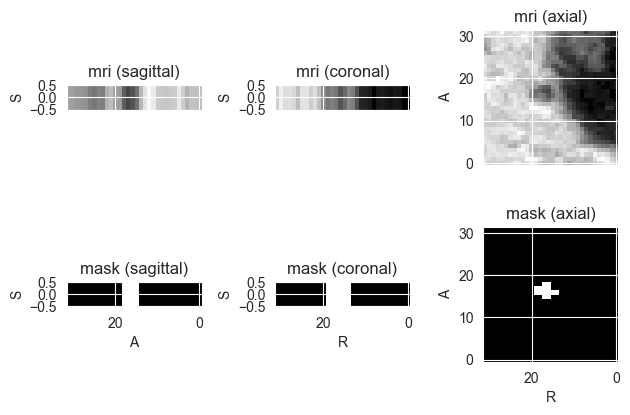

Augmented


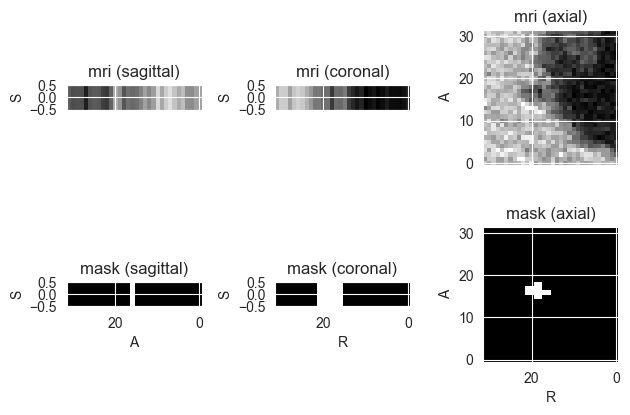

Original vs Augmented SSIM: tensor(0.3830)
Full scan SSIM: tensor(0.8433)
Original


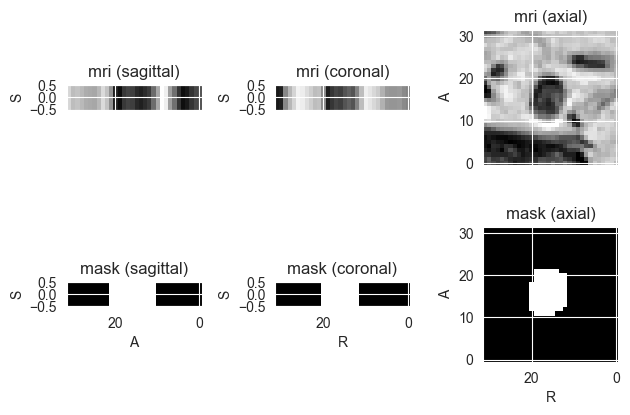

Augmented


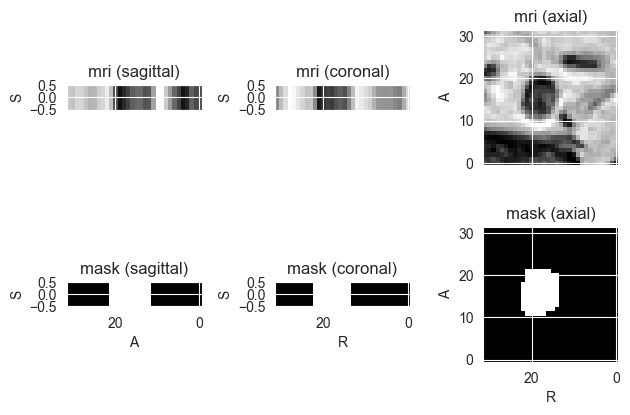

Original vs Augmented SSIM: tensor(0.4958)
Full scan SSIM: tensor(0.8097)
Original


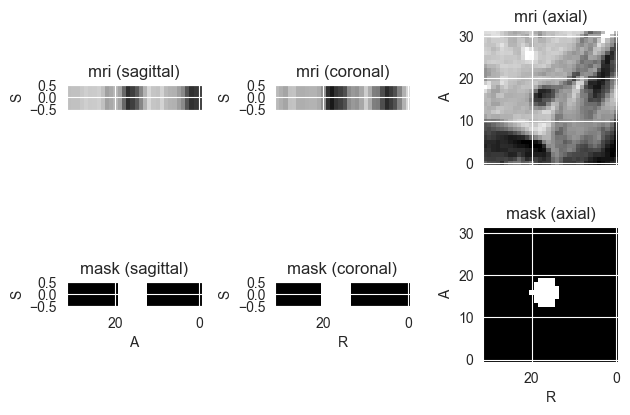

Augmented


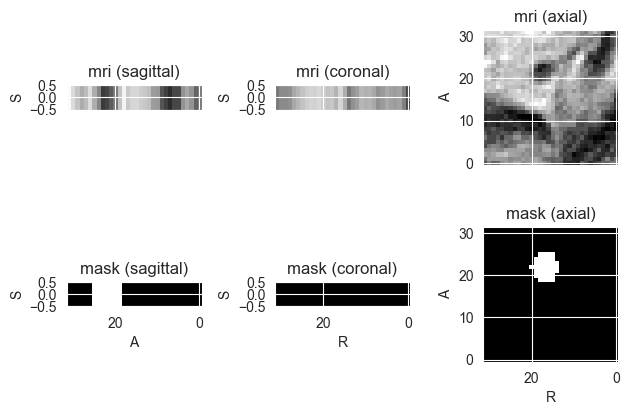

Original vs Augmented SSIM: tensor(0.0300)
Number of augmented lymph node slices in dataset: 39225.0
Time to create dataset: 2596.6558991000056
missed samples: []


In [15]:
if save_augmented_data:
    time_start = perf_counter()
    missed_samples = []
    samples = 0
    for i, mri_path in enumerate(mri_nii_paths):
        mask_path = mask_nii_paths[i]
        assert mri_nii_paths[i][63:72] == mask_nii_paths[i][63:72] # check same patient id
        
        original_bbox = bounding_boxes_dict[mask_path]
        keys = list(original_bbox.keys())
        
        augment = tio.Compose([
            tio.RandomBlur(std=(0, 0.05), p=0.3),             # blur 
            tio.RandomNoise(mean=0, std=(0, 0.05), p=0.3),    # Gaussian noise 
            tio.RandomFlip(axes=(0, 1), p=0.5),               # flip 50% of times
            tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.3),    # Adjusts gamma with specified range and probability
            tio.RandomBiasField(coefficients=0.25,            # magnetic field inhomogeneity 30% of times
                                order=3, p=0.3),
            # tio.RandomAffine(                                  # Apply random affine transformation
            #     degrees=(15,15,0),     # Rotate in x and y but not slice dimension (z)
            #     translation=(0, 0, 0), # No translation 
            #     scales=(1.0, 1.0),     # No scaling
            #     p=0.5),
            
            # maybe don't include scales and elastic as they change shape of node - matters more for the MLP
            # tio.RandomElasticDeformation(                  # or random elastic deformation
            #     num_control_points=5,
            #     max_displacement=2, p=0.3),
            
            # these augmentations may not be appropriate on 32x32 ROI
            # tio.OneOf({                                        # either
            #     tio.RandomMotion(degrees=5,                    # random motion artifact - changes image too much
            #                      translation=5): 0.2,
            #     tio.RandomSpike(num_spikes=1,                  # or spikes
            #                     intensity=0.75): 0.4,
            #     tio.RandomGhosting(num_ghosts=3,               # or ghosts
            #                        axes=(0, 1, 2),
            #                        intensity=0.5): 0.4,
            # }, p=0.5),      
            tio.RescaleIntensity(out_min_max=(0, 1))  # Normalize intensity values to the range [0, 1]
        ])
        
        for aug_idx in range(25): # 25 augmentations per image
            subject = tio.Subject(
                mri=tio.ScalarImage(mri_path),
                mask=tio.LabelMap(mask_path),
            )
            subject_aug = augment(subject)
            mri = torch.unsqueeze(subject['mri'].data.permute(0, 3, 1, 2), 0)
            mri_aug = torch.unsqueeze(subject_aug['mri'].data.permute(0, 3, 1, 2), 0)
            #print('(Full Scan) Original vs Augmented SSIM:', pytorch_msssim.ssim(mri, mri_aug, data_range=1))
            mask = subject_aug['mask'].data
            mask = np.squeeze(np.array(mask), 0)
            mask = np.transpose(mask, (2, 0, 1))
            bboxes_dict = find_centers_and_bounding_boxes_32(mask)
            # add noise to x and y coordinates of bounding boxes
            bboxes_dict = add_noise_to_bbox(bboxes_dict, mri_shape=mask.shape)

    
            key_idx = -1
            #print(bboxes_dict)
            for bbox_key, bbox_info in bboxes_dict.items():
                key_idx += 1
                # print(key_idx, aug_idx)
                # print(key_idx, bbox_key, keys[key_idx], bbox_info, original_bbox[keys[key_idx]])
                bbox = bbox_info['bounding_box']
        
                # Get bounding box coordinates (in format (x_min, y_min, z_min), (x_max, y_max, z_max))
                z_min, x_min, y_min = bbox[0]
                z_max, x_max, y_max = bbox[1]
    
                for key, img in subject_aug.items():
                    data = img.data   # Convert to a PyTorch tensor
                    #print(key, data.shape)
                    cropped_data = data[:, x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
                    if cropped_data.shape == (1, 32, 32, 1):
                        cropped_image = tio.ScalarImage(tensor=cropped_data, affine=img.affine)
                        if key == 'mask':
                            data = cropped_image.data
                            assert data.sum() != 0
            
                        # Save the cropped image as a NIfTI file
                        if key == 'mri':
                            save_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices\mri_aug\{}_{}_{}_{}_{}.nii".format(
                            mri_path[63:-4], i, int(bbox_key[0]), int(bbox_key[1]), aug_idx) # (patient number, patient LN number, slice_idx, augmentation idx)
                        if key == 'mask':
                            save_path = r"C:\Users\mm17b2k.DS\Documents\ARCANE_Data\Cohort1_2D_slices\mask_aug\{}_{}_{}_{}_{}.nii".format(
                            mask_path[63:-4], i, int(bbox_key[0]), int(bbox_key[1]), aug_idx) # (patient number, patient LN number, slice_idx, augmentation idx)
            
                        cropped_image.save(save_path)
                        samples += 1
                        
                        if i % 50 == 0 and samples % 150 == 0:
                            print('Full scan SSIM:', pytorch_msssim.ssim(subject['mri'].data, subject_aug['mri'].data, data_range=1))
                            random_idx = random.randint(0, len(original_bbox)-1)
                            print('Original')
                            original = crop_and_plot(subject, random_idx, original_bbox)
                            print('Augmented')
                            augmented = crop_and_plot(subject_aug, random_idx, bboxes_dict)
                            original_mri = original['mri'].data.permute(0, 3, 1, 2)
                            augmented_mri = augmented['mri'].data.permute(0, 3, 1, 2)
                            assert original_mri.shape == augmented_mri.shape == (1, 1, 32, 32)
                            assert pytorch_msssim.ssim(original_mri, original_mri, data_range=1) == 1
                            print('Original vs Augmented SSIM:', pytorch_msssim.ssim(original_mri, augmented_mri, data_range=1))



                    else:
                            print('missed sample', cropped_data.shape, bbox_key, i, aug_idx)
                            missed_samples.append((i, aug_idx, bbox_key))
                    

                    
    
    
    print('Number of augmented lymph node slices in dataset:', samples/2)
    print("Time to create dataset:", perf_counter() - time_start) #  seconds
    print('missed samples:', missed_samples)
    
# Original vs Augmented SSIM: tensor(0.0300)
# Number of augmented lymph node slices in dataset: 39225.0
# Time to create dataset: 2596.6558991000056
# missed samples: []